<a href="https://colab.research.google.com/github/rahuliyer/ai_experiments/blob/main/Leopard_or_Cheetah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leopard, Cheetah, or Jaguar?

This is a notebook to download images from Duck Duck Go and detect whether a picture is that of a leopard, cheetah, or a jaguar.

## Install libraries

In [37]:
#hide
!pip install -Uqq fastai duckduckgo-search

## Prepare the data set

First search for images using the Duck Duck Go library

In [38]:
from duckduckgo_search import DDGS

In [39]:
def search_images(term, max_images=30):
  with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term, max_results=max_images)
        # grap number of max_images urls
        image_urls = [next(iter(search_results)).get("image") for _ in range(max_images)]

        return image_urls

Download the images and check if they are ok

In [40]:
from fastdownload import download_url
from fastai.vision.all import *

cheetah_image_urls = search_images("cheetah photos", max_images=1)
cheetah_image_urls[0]


'https://www.rd.com/wp-content/uploads/2019/11/cheetah-1.jpg'

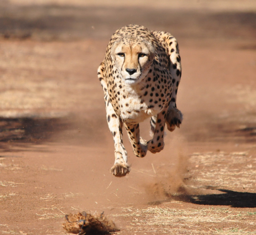

In [41]:
filename = 'cheetah.jpg'
download_url(cheetah_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [42]:
leopard_image_urls = search_images("leopard photos", max_images=1)
leopard_image_urls[0]


'http://www.animalspot.net/wp-content/uploads/2017/06/African-Leopard.jpg'

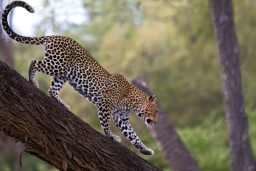

In [43]:
filename = 'leopard.jpg'
download_url(leopard_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [44]:
jaguar_image_urls = search_images("jaguar photos", max_images=1)
jaguar_image_urls[0]

'https://images.squarespace-cdn.com/content/v1/56a1a14b05caa7ee9f26f47d/1582497584871-UKC9NH3F8WIW4ANHAB2H/jaguar-snarl_IS.jpg'

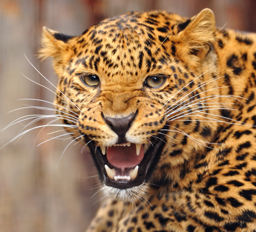

In [45]:
filename = 'jaguar.jpg'
download_url(jaguar_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

Create a function to download images with sleeps so we don't hammer the server

In [46]:
def download_images_with_interval(urls, dest, batch_size=10, sleep_interval=10):
  index = 0
  while index < len(urls):
    urls_to_download = urls[index:index + batch_size]
    download_images(dest, urls=urls_to_download)
    sleep(sleep_interval)
    index += batch_size


In [47]:
from time import sleep
from pathlib import Path

searches = ['cheetah', 'leopard', 'jaguar']

search_urls = {}

for search in searches:
  search_urls[search] = search_images(f"{search} images", max_images=100)


Download the images into the following tree structure:
```
- data/
    - cheetah/
    - leopard/
    - jaguar/
```



In [48]:
data_dir = Path('data')

if not data_dir.exists():
    max_before_sleep = 10
    sleep_interval = 10
    
    for search in search_urls:
      dest_dir = f"{data_dir}/{search}"
      Path(dest_dir).mkdir(exist_ok=True, parents=True)
    
      download_images_with_interval(search_urls[search], dest_dir)


Clean images that did not download properly

In [49]:
failed = verify_images(get_image_files(data_dir))
failed.map(Path.unlink)

(#0) []

## Training

In [50]:
def clear_gpu_cache():
    import gc
    gc.collect()
    torch.cuda.empty_cache()

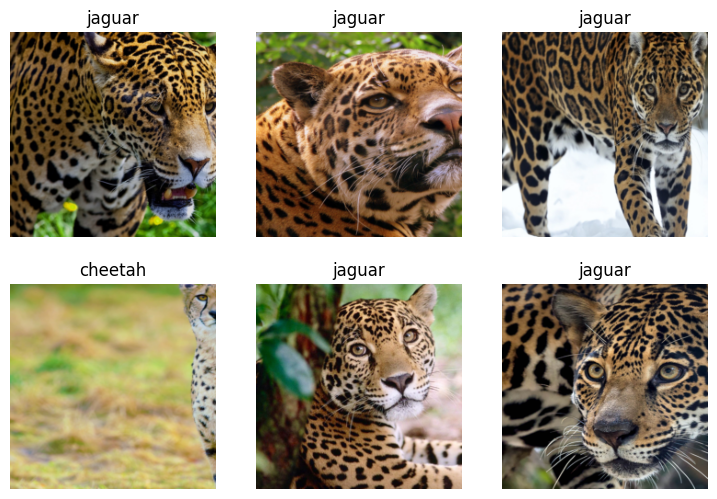

In [51]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(224, min_scale=0.3)]
).dataloaders(data_dir, bs=32)

dls.show_batch(max_n=6)

In [52]:
callbacks = [
    SaveModelCallback(monitor='valid_loss'),
    EarlyStoppingCallback(monitor='valid_loss', patience=5)
]

learn = vision_learner(dls, resnet18, metrics=error_rate, cbs=callbacks)
learn.fine_tune(30)

Better model found at epoch 0 with valid_loss value: 0.4677327573299408.


Better model found at epoch 0 with valid_loss value: 0.46354180574417114.
Better model found at epoch 1 with valid_loss value: 0.4373624324798584.
Better model found at epoch 2 with valid_loss value: 0.42076176404953003.
Better model found at epoch 3 with valid_loss value: 0.4075413644313812.
No improvement since epoch 3: early stopping


In [53]:
learn.predict(PILImage.create('cheetah.jpg'))

('cheetah', tensor(0), tensor([9.9374e-01, 5.9672e-03, 2.9504e-04]))

In [54]:
learn.predict(PILImage.create('leopard.jpg'))

('leopard', tensor(2), tensor([0.0390, 0.0054, 0.9556]))

In [55]:
learn.predict(PILImage.create('jaguar.jpg'))

('leopard', tensor(2), tensor([4.6514e-04, 6.9274e-03, 9.9261e-01]))

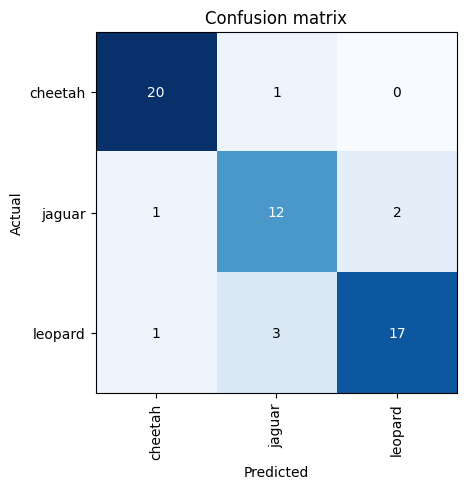

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

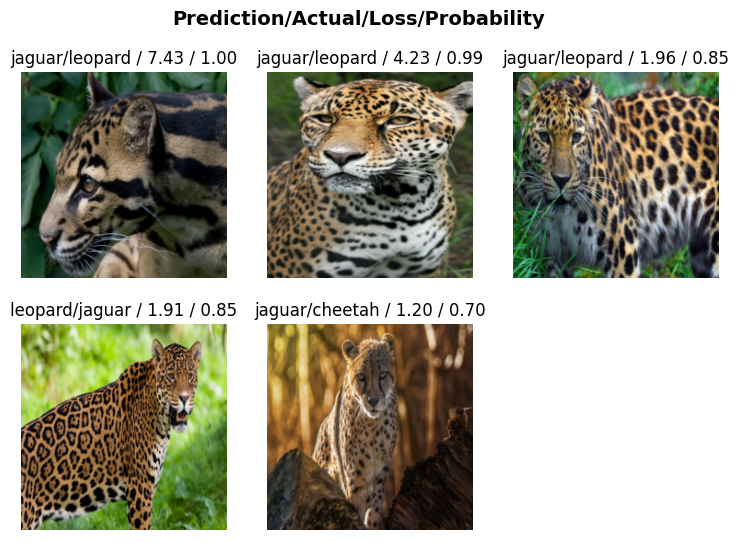

In [57]:
interp.plot_top_losses(5)

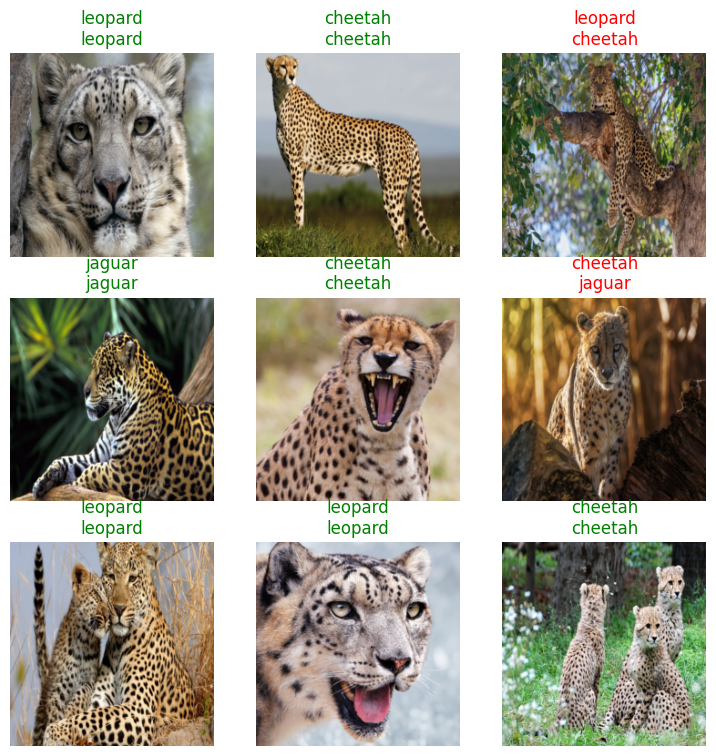

In [58]:
learn.show_results()

Now let's try a bigger model

In [59]:
del learn
clear_gpu_cache()

In [60]:
learn = vision_learner(dls, resnet50, metrics=error_rate, cbs=callbacks)
learn.fine_tune(30)

Better model found at epoch 0 with valid_loss value: 0.33183571696281433.


Better model found at epoch 0 with valid_loss value: 0.26341086626052856.
Better model found at epoch 1 with valid_loss value: 0.26030024886131287.
Better model found at epoch 3 with valid_loss value: 0.25659090280532837.
Better model found at epoch 4 with valid_loss value: 0.23386700451374054.
No improvement since epoch 4: early stopping


In [61]:
learn.predict(PILImage.create('cheetah.jpg'))

('cheetah', tensor(0), tensor([9.7541e-01, 2.4541e-02, 5.1478e-05]))

In [62]:
learn.predict(PILImage.create('leopard.jpg'))

('leopard', tensor(2), tensor([1.8703e-04, 1.2824e-03, 9.9853e-01]))

In [63]:
learn.predict(PILImage.create('jaguar.jpg'))

('jaguar', tensor(1), tensor([1.2171e-04, 9.9092e-01, 8.9601e-03]))

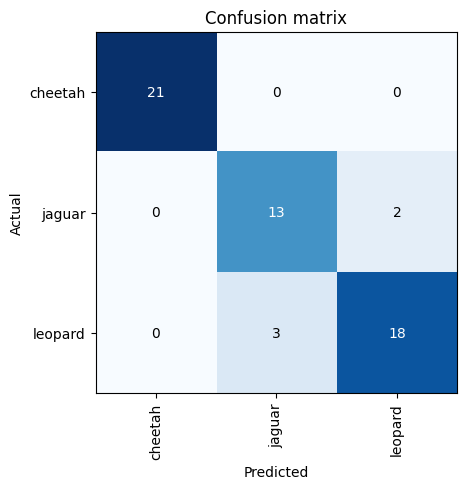

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

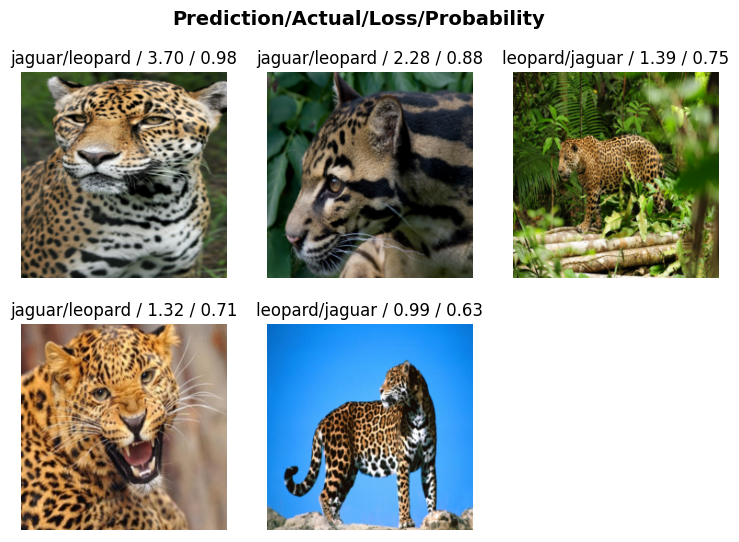

In [65]:
interp.plot_top_losses(5)

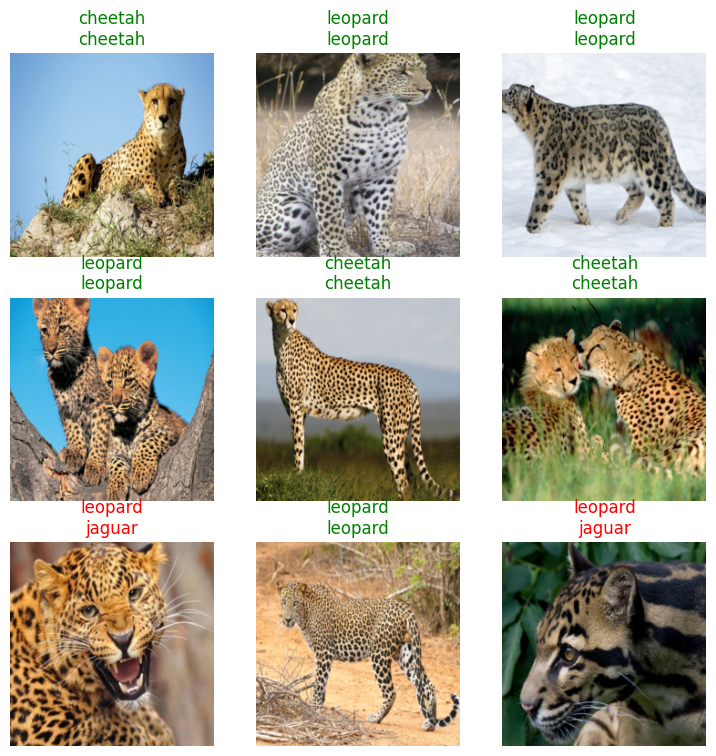

In [66]:
learn.show_results()

Let's clean the data and remove images that aren't predictive or mislabeled

In [67]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [73]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Let us now retrain the model after having cleaned the data.

In [75]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(224, min_scale=0.3)]
).dataloaders(data_dir, bs=32)

learn = vision_learner(dls, resnet50, metrics=error_rate, cbs=callbacks)
learn.fine_tune(30)

Better model found at epoch 0 with valid_loss value: 0.3316032588481903.


Better model found at epoch 0 with valid_loss value: 0.29304176568984985.
Better model found at epoch 1 with valid_loss value: 0.2639789879322052.
Better model found at epoch 2 with valid_loss value: 0.228677436709404.
Better model found at epoch 3 with valid_loss value: 0.21710702776908875.
Better model found at epoch 4 with valid_loss value: 0.20149625837802887.
No improvement since epoch 4: early stopping


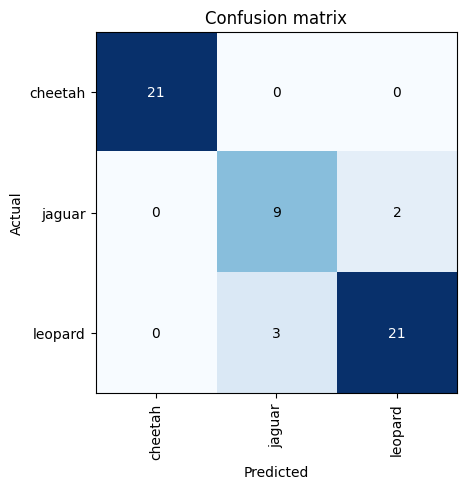

In [76]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

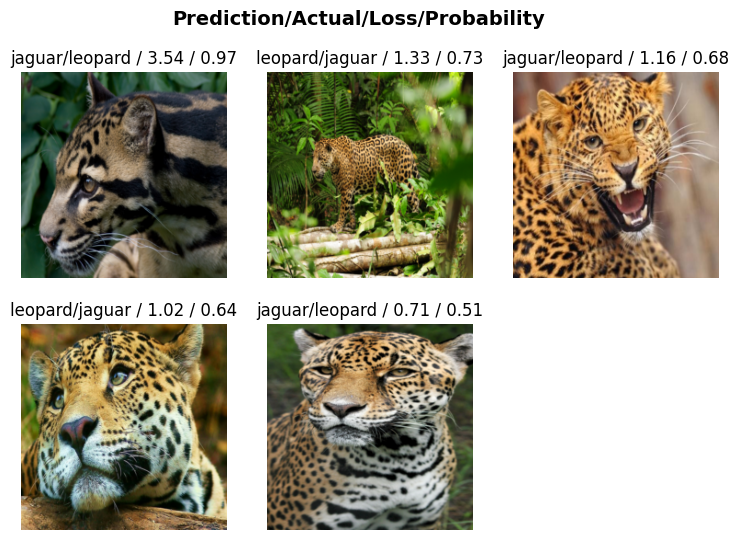

In [77]:
interp.plot_top_losses(5)

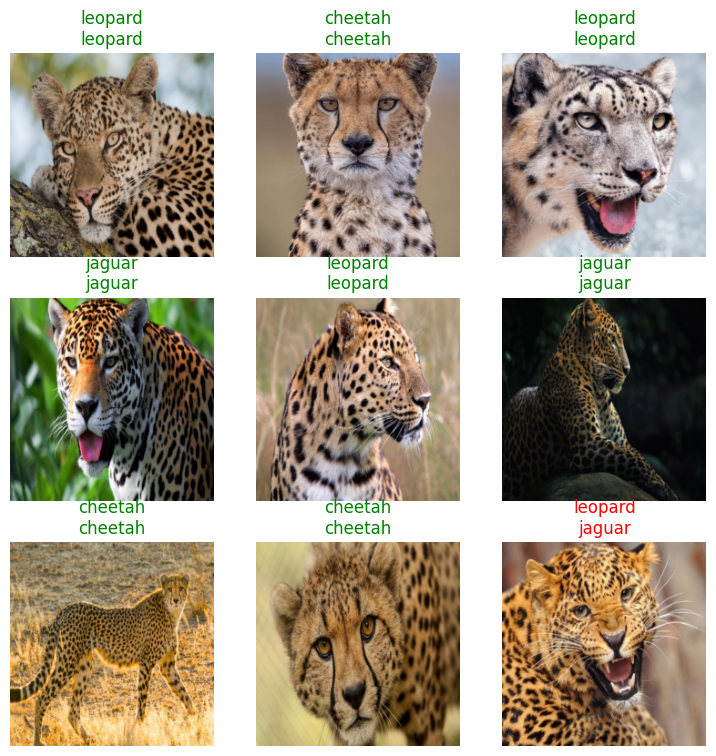

In [78]:
learn.show_results()

Let's save the model now.

In [79]:
learn.export("clj_model.pkl")